# Рекомендательная система онлайн-киносервиса

- Рекомендательная система фильмов построена на базе датасета MovieLens
- Все фильмы оцениваются по шкале от 0.5 до 5 баллов
- Используются подходы:
  - 1) content-based (item-to-item)
  - 2) user-based CF *(с применением Surprise, примером диалоговой работы RS)*
  - 3) item-based CF *(с применением Surprise)*
  - 4) ANN-based
  - 5) SVD
  - 6) NMF
  - 7) hybrid *(с применением lightFM)*
  - 8) "холодный старт" (рекомендации для новых пользователей)
- Качество по подходам 1-6 оценивается по метрике RMSE
- Итоговое сравнение RMSE моделей и выводы приведены в конце ноутбука

### Загрузка библиотек, подготовка данных

In [300]:
import pandas as pd
import numpy as np
import random

# !pip install surprise
from surprise import KNNWithMeans, KNNBaseline, KNNBasic, KNNWithZScore
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

from scipy.spatial.distance import cosine

import warnings
warnings.filterwarnings("ignore")

In [299]:
!wget 'https://drive.google.com/uc?id=1m0rwReR09achL0xTM6QPoN4tykz5bOMx' -O MovieLens.zip

--2023-08-04 11:02:30--  https://drive.google.com/uc?id=1m0rwReR09achL0xTM6QPoN4tykz5bOMx
Resolving drive.google.com (drive.google.com)... 74.125.141.139, 74.125.141.138, 74.125.141.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vrio04i7917eg5arempcekqreajn0qm3/1691146950000/02611596255248067438/*/1m0rwReR09achL0xTM6QPoN4tykz5bOMx?uuid=4fdadfb2-0644-44a4-a1b2-2d8d4bfc9d9f [following]
--2023-08-04 11:02:31--  https://doc-0g-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vrio04i7917eg5arempcekqreajn0qm3/1691146950000/02611596255248067438/*/1m0rwReR09achL0xTM6QPoN4tykz5bOMx?uuid=4fdadfb2-0644-44a4-a1b2-2d8d4bfc9d9f
Resolving doc-0g-84-docs.googleusercontent.com (doc-0g-84-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-0

In [301]:
!unzip MovieLens.zip

Archive:  MovieLens.zip
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [302]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

In [261]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [262]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [263]:
movs_merged = movies.merge(ratings, on='movieId').reset_index(drop=True)
movs_merged.dropna(inplace=True)
movs_merged.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [264]:
# подготовка датасета для библиотеки Surprise

df_surp = pd.DataFrame({
                        'uid': movs_merged['userId'],
                        'iid': movs_merged['title'],
                        'rating': movs_merged['rating']
                        })

df_surp.head()

,uid,iid,rating
0,1,Toy Story (1995),4.0
1,5,Toy Story (1995),4.0
2,7,Toy Story (1995),4.5
3,15,Toy Story (1995),2.5
4,17,Toy Story (1995),4.5


In [265]:
reader = Reader(rating_scale=(df_surp['rating'].min(), df_surp['rating'].max()))
data = Dataset.load_from_df(df_surp, reader)

In [266]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=23)

In [267]:
print(f"Количество пользователей: {df_surp['uid'].nunique()}")
print(f"Количество фильмов: {df_surp['iid'].nunique()}")

Количество пользователей: 610
Количество фильмов: 9719


### 1. Content-based (item-to-item):

#### 1.1. Простейшая content-based RS:

In [268]:
movs_merged.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [269]:
movs_merged['title'].value_counts()

Forrest Gump (1994)                      329
Shawshank Redemption, The (1994)         317
Pulp Fiction (1994)                      307
Silence of the Lambs, The (1991)         279
Matrix, The (1999)                       278
                                        ... 
We're Back! A Dinosaur's Story (1993)      1
American Hardcore (2006)                   1
Shanghai Surprise (1986)                   1
Let's Get Harry (1986)                     1
Andrew Dice Clay: Dice Rules (1991)        1
Name: title, Length: 9719, dtype: int64

In [270]:
movs_merged['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
53       20
207      20
431      20
442      20
189      20
Name: userId, Length: 610, dtype: int64

In [271]:
num_users = movs_merged['userId'].unique().shape[0]
num_users

610

In [272]:
movie_vector = {}

for movie, group in movs_merged.groupby('title'):
    movie_vector[movie] = np.zeros(num_users)

    for i in range(len(group['userId'].values)):
        u = group.userId.values[i]
        r = group.rating.values[i]
        movie_vector[movie][int(u - 1)] = r

In [315]:
base_film = input('1 - Ввести фильм вручную\n2 - Получить рекомендацию для случайного фильма\n')
if base_film == 1:
    base_film = input('Введите фильм')
else:
    base_film = random.choice(list(set(movs_merged['title'])))
print(f'Для формирования рекомендаций выбран фильм: {base_film}')

1 - Ввести фильм вручную
2 - Получить рекомендацию для случайного фильма
2
Для формирования рекомендаций выбран фильм: Wild Wild West (1999)


In [316]:
try:
    movie_vector[base_film]
except:
    print('Такой фильм отсутствует в базе данных!')

In [317]:
movie_vector[base_film]

array([0. , 0. , 0. , 0. , 0. , 0. , 1.5, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 1.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,
       0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 2. ,
       0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. , 2. , 0. , 0. ,
       0. , 3. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 2. , 0. , 0. , 0. , 0.

In [318]:
# формирование списка расстояний между выбранным фильмом и другими фильмами

titles = []
distances = []

for key in movie_vector.keys():
    if key == base_film:
        continue

    titles.append(key)
    distances.append(cosine(movie_vector[base_film], movie_vector[key]))

In [319]:
target_qty = int(input('Введите желаемое количество рекомендуемых фильмов, похожих на заданный:\t'))

Введите желаемое количество рекомендуемых фильмов, похожих на заданный:	10


In [320]:
# определение заданного количества наиболее "близких" к исходному фильмов
best_indexes = np.argsort(distances)[:target_qty]
best_movies = [(titles[i], distances[i]) for i in best_indexes]
print('На базе выбранного фильма рекомендуются к просмотру (фильм, косинусное расстояние):')
for movie in best_movies:
    print(f'{movie[0]}, косинусное расстояние: {round(movie[1], 3)}')

На базе выбранного фильма рекомендуются к просмотру (фильм, косинусное расстояние):
Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002), косинусное расстояние: 0.51
League of Extraordinary Gentlemen, The (a.k.a. LXG) (2003), косинусное расстояние: 0.517
Godzilla (1998), косинусное расстояние: 0.522
Boondock Saints, The (2000), косинусное расстояние: 0.527
Charlie's Angels (2000), косинусное расстояние: 0.53
X-Men (2000), косинусное расстояние: 0.533
What Women Want (2000), косинусное расстояние: 0.534
Who Framed Roger Rabbit? (1988), косинусное расстояние: 0.538
Con Air (1997), косинусное расстояние: 0.538
Daredevil (2003), косинусное расстояние: 0.539


#### 1.2. Content-based RS на тегах и жанрах, средних оценках пользователя и фильма

In [366]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [368]:
df_merged = pd.merge(ratings, movies, on='movieId', how='left')
# преобразование признака genres, добавление тегов из df_tags (через пробел)
df_merged['genres'] = df_merged.apply(lambda x: ' '.join(x['genres'].split('|')), axis=1)
df_merged['tags'] = df_merged.apply(lambda x: ' '.join(tags[tags['movieId']==x['movieId']]['tag'].values), axis=1)
df_merged.head()

,userId,movieId,rating,timestamp,title,genres,tags
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy Romance,moldy old
2,1,6,4.0,964982224,Heat (1995),Action Crime Thriller,
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery Thriller,mystery twist ending serial killer
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime Mystery Thriller,mindfuck suspense thriller tricky twist ending...


In [369]:
tfidf = TfidfTransformer()
c_v = CountVectorizer()
sc = StandardScaler()

In [370]:
def get_tfidf(data, feature):
    '''
    функция возвращает tfidf записей
    '''
    X_train_count = c_v.fit_transform(data[feature])
    X_train_tfidf = tfidf.fit_transform(X_train_count).toarray()
    col = [col for col in range(len(c_v.vocabulary_))]
    for x in c_v.vocabulary_:
        col[c_v.vocabulary_[x]] = x
    df_tfidf = pd.DataFrame(X_train_tfidf, columns=col)
    return pd.concat((data.drop(feature, 1), df_tfidf), axis=1)

In [371]:
def user_recom(df, model_rec, user_id):
    '''
    функция возвращает рекомендации
    '''
    y = df[df['userId']==user_id]['rating']
    X = df[df['userId']==user_id].drop(['userId', 'movieId', 'timestamp', 'title', 'rating'], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    X_train = sc.fit_transform(X_train)
    model = model_rec
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'User: {user_id}, model: {str(model_rec).split("(")[0]}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    return X_test, y_pred

In [372]:
movs_tfidf = get_tfidf(df_merged, 'genres')
movs_tfidf = get_tfidf(movs_tfidf, 'tags')
movs_tfidf.head()

,userId,movieId,rating,timestamp,title,action,adventure,animation,children,comedy,...,york,you,younger,your,zellweger,zither,zoe,zombie,zombies,zooey
0,1,1,4.0,964982703,Toy Story (1995),0.000000,0.363885,0.549735,0.508407,0.291944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),0.000000,0.000000,0.000000,0.000000,0.582902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6,4.0,964982224,Heat (1995),0.515013,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [373]:
# для обучения модели будем использовать данные по наиболее активным пользователям
best_users = df_merged.groupby(['userId'])['rating'].count().sort_values(ascending=False).index[0]

In [374]:
df_pred, y_pred = user_recom(movs_tfidf, DecisionTreeRegressor(), best_users)

User: 414, model: DecisionTreeRegressor, RMSE: 1.0834833229501555


In [375]:
# формирование предсказаний рейтинга
df_made_pred = pd.concat([df_pred.reset_index(), pd.DataFrame(columns=['prediction_(rating)'],
            data=y_pred)], axis=1)
df = pd.merge(movs_tfidf[['movieId', 'title', 'rating']].reset_index(),
                    df_made_pred[['index', 'prediction_(rating)']], how='inner', on='index')
df.drop(['index'], axis=1).head()

,movieId,title,rating,prediction_(rating)
0,2,Jumanji (1995),3.0,4.0
1,7,Sabrina (1995),3.0,4.0
2,21,Get Shorty (1995),4.0,4.0
3,23,Assassins (1995),2.0,4.0
4,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),5.0,4.0


In [377]:
# средние оценки пользователей и фильмов
user_rating = ratings.groupby('userId')['rating'].agg(['mean','median','std','var']).reset_index()
movie_rating = ratings.groupby('movieId')['rating'].agg(['mean','median','std','var']).reset_index()
user_rating.head()

,userId,mean,median,std,var
0,1,4.366379,5.0,0.800048,0.640077
1,2,3.948276,4.0,0.805615,0.649015
2,3,2.435897,0.5,2.090642,4.370783
3,4,3.555556,4.0,1.314204,1.727132
4,5,3.636364,4.0,0.990441,0.980973


In [378]:
movie_rating.head()

,movieId,mean,median,std,var
0,1,3.920930,4.0,0.834859,0.696990
1,2,3.431818,3.5,0.881713,0.777419
2,3,3.259615,3.0,1.054823,1.112651
3,4,2.357143,3.0,0.852168,0.726190
4,5,3.071429,3.0,0.907148,0.822917


In [379]:
movs_tfidf_mean = pd.merge(movs_tfidf, user_rating, on='userId')

movs_tfidf_mean.rename(columns={
    'mean': ' user_mean',
    'median': 'user_median',
    'std': 'user_std',
    'var': 'user_var'
}, inplace=True)

movs_tfidf_mean = pd.merge(movs_tfidf_mean, movie_rating, on='movieId')

movs_tfidf_mean.rename(columns={
    'mean': ' movie_mean',
    'median': 'movie_median',
    'std': 'movie_std',
    'var': 'movie_var'
}, inplace=True)

movs_tfidf_mean.fillna(0, inplace=True)

movs_tfidf_mean.head()

,userId,movieId,rating,timestamp,title,action,adventure,animation,children,comedy,...,zombies,zooey,user_mean,user_median,user_std,user_var,movie_mean,movie_median,movie_std,movie_var
0,1,1,4.0,964982703,Toy Story (1995),0.0,0.363885,0.549735,0.508407,0.291944,...,0.0,0.0,4.366379,5.0,0.800048,0.640077,3.92093,4.0,0.834859,0.69699
1,5,1,4.0,847434962,Toy Story (1995),0.0,0.363885,0.549735,0.508407,0.291944,...,0.0,0.0,3.636364,4.0,0.990441,0.980973,3.92093,4.0,0.834859,0.69699
2,7,1,4.5,1106635946,Toy Story (1995),0.0,0.363885,0.549735,0.508407,0.291944,...,0.0,0.0,3.230263,3.5,1.329594,1.767820,3.92093,4.0,0.834859,0.69699
3,15,1,2.5,1510577970,Toy Story (1995),0.0,0.363885,0.549735,0.508407,0.291944,...,0.0,0.0,3.448148,3.5,1.133404,1.284605,3.92093,4.0,0.834859,0.69699
4,17,1,4.5,1305696483,Toy Story (1995),0.0,0.363885,0.549735,0.508407,0.291944,...,0.0,0.0,4.209524,4.0,0.508490,0.258562,3.92093,4.0,0.834859,0.69699


In [380]:
df_pred, y_pred = user_recom(movs_tfidf_mean, DecisionTreeRegressor(), best_users)

df_made_pred = pd.concat([df_pred.reset_index(), pd.DataFrame(columns=['prediction_(rating)'],
            data=y_pred)], axis=1)
df = pd.merge(movs_tfidf_mean[['movieId', 'title', 'rating']].reset_index(),
                    df_made_pred[['index', 'prediction_(rating)']], how='inner', on='index')
df.drop(['index'], axis=1).head()

User: 414, model: DecisionTreeRegressor, RMSE: 1.0507492917314167


,movieId,title,rating,prediction_(rating)
0,3,Grumpier Old Men (1995),4.0,3.0
1,216,Billy Madison (1995),3.0,3.0
2,260,Star Wars: Episode IV - A New Hope (1977),5.0,3.0
3,316,Stargate (1994),3.0,3.0
4,356,Forrest Gump (1994),5.0,3.0


In [387]:
rmse_content = (((df['prediction_(rating)'] - df['rating'])**2).mean())**0.5      # для произведенного расчета (пользователь 414)
algo_content = 'Content-based'

### 2. User-based:

In [279]:
def get_prediction(algorithm):
    '''
    Функция формирует предсказание, оценивает RMSE
    '''
    print('--------')
    algo = algorithm
    algo.fit(trainset)
    predictions = algo.test(testset)
    # print(f'Алгоритм {str(algorithm).split(".")[3].split(" ")[0]}: ', accuracy.rmse(predictions))
    return (str(algorithm).split(".")[3].split(" ")[0], accuracy.rmse(predictions))

In [280]:
algos_ub = [
            KNNWithMeans(k=50, min_k=10, sim_options={'name': 'cosine', 'user_based': True}),
            KNNBaseline(k=30, sim_options={'name': 'msd', 'user_based': True}),
            KNNWithZScore(sim_options={'name': 'cosine', 'user_based': True}),
            KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
            ]

In [281]:
rmse_ub = {}

for algo in algos_ub:
    name, metric = get_prediction(algo)
    rmse_ub[name] = metric
    print(f'Алгоритм: {name}')

--------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9091
Алгоритм: KNNWithMeans
--------
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8792
Алгоритм: KNNBaseline
--------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9027
Алгоритм: KNNWithZScore
--------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9771
Алгоритм: KNNBasic


In [282]:
# Метрики (RMSE) алгоритмов (от лучшего к худшему)
sorted(rmse_ub.items(), key=lambda x: round(x[1], 4))

[('KNNBaseline', 0.8791650569449327),
 ('KNNWithZScore', 0.9027062027168693),
 ('KNNWithMeans', 0.9090843996348236),
 ('KNNBasic', 0.9771120950320485)]

In [283]:
# лучшая метрика RMSE получена на алгоритмe KNNBaseline
# проведем повторный фит модели (для дальнейшего использования при формировании рекомендаций)

best_algo_ub = KNNBaseline(k=30, sim_options={'name': 'msd', 'user_based': True})
best_algo_ub.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [284]:
# сохранение лучшего алгоритмы и его метрики для последующего сравнения
algo_best_ub = sorted(rmse_ub.items(), key=lambda x: x[1])[0][0]
rmse_best_ub = sorted(rmse_ub.items(), key=lambda x: x[1])[0][1]

#### *Пример работы рекомендательной системы (на базе user-based подхода):*

In [285]:
def generate_rec_user_based(uid, model, dataset, qty):
    '''
    Функция генерирует заданное число рекомендаций для заданного пользователя
    '''
    all_titles = list(dataset['iid'].values)
    users_seen_titles = dataset[dataset['uid'] == uid]['iid']
    titles = np.array(list(set(all_titles) - set(users_seen_titles)))

    np.random.shuffle(titles)

    rec_list = []
    for title in titles:
        review_prediction = model.predict(uid=uid, iid=title)
        rating = review_prediction.est
        rec_list.append((title, round(rating, 2)))

    print('Рекомендуемые к просмотру фильмы (название, прогнозная оценка):\n')
    return sorted(rec_list, key=lambda x: x[1], reverse=True)[:qty]

In [286]:
target_user = int(input('Введите uid пользователя, для которого необходимо сформировать рекомендацию:\t'))

Введите uid пользователя, для которого необходимо сформировать рекомендацию:	10


In [287]:
target_qty = int(input('Введите желаемое количество рекомендуемых фильмов:\t'))

Введите желаемое количество рекомендуемых фильмов:	10


In [288]:
print('10 наиболее высоко оцененных целевым пользователем фильмов:\n')
df_surp[['iid', 'rating']][(df_surp['uid']==target_user) & (df_surp['rating']>0)].\
                      sort_values(by='rating', ascending=False)[:10].style.hide_index()

10 наиболее высоко оцененных целевым пользователем фильмов:



iid,rating
The Intern (2015),5.000000
First Daughter (2004),5.000000
Skyfall (2012),5.000000
"Dark Knight Rises, The (2012)",5.000000
Troy (2004),5.000000
"King's Speech, The (2010)",5.000000
"Notebook, The (2004)",5.000000
Despicable Me (2010),5.000000
"Education, An (2009)",5.000000
Batman Begins (2005),5.000000


In [289]:
generate_rec_user_based(target_user, best_algo_ub, df_surp, target_qty)

Рекомендуемые к просмотру фильмы (название, прогнозная оценка):



[('On the Beach (1959)', 5.0),
 ('Unfaithfully Yours (1948)', 5.0),
 ('Paterson', 5.0),
 ('Jetée, La (1962)', 5.0),
 ('Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)', 5.0),
 ('The Big Bus (1976)', 5.0),
 ('Seve (2014)', 5.0),
 ('Come and See (Idi i smotri) (1985)', 5.0),
 ('Bossa Nova (2000)', 4.98),
 ('Strictly Sexual (2008)', 4.97)]

### 3. Item-based:

In [290]:
algos_ib = [
            KNNWithMeans(k=50, min_k=10, sim_options={'name': 'cosine', 'user_based': False}),
            KNNBaseline(k=30, sim_options={'name': 'msd', 'user_based': False}),
            KNNWithZScore(sim_options={'name': 'cosine', 'user_based': False}),
            KNNBasic(sim_options={'name': 'cosine', 'user_based': False})
            ]

In [291]:
rmse_ib = {}

for algo in algos_ib:
    name, metric = get_prediction(algo)
    rmse_ib[name] = metric
    print(f'Алгоритм: {name}')

--------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9060
Алгоритм: KNNWithMeans
--------
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8757
Алгоритм: KNNBaseline
--------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9137
Алгоритм: KNNWithZScore
--------
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9821
Алгоритм: KNNBasic


In [292]:
# Метрики (RMSE) алгоритмов (от лучшего к худшему)
sorted(rmse_ib.items(), key=lambda x: x[1])

[('KNNBaseline', 0.8756950491289859),
 ('KNNWithMeans', 0.9060030948268133),
 ('KNNWithZScore', 0.9136957611775348),
 ('KNNBasic', 0.9821231352795289)]

In [293]:
# лучшая метрика RMSE также получена на алгоритмe KNNBaseline
# сохранение лучшего алгоритмы и его метрики для последующего сравнения:
algo_best_ib = sorted(rmse_ib.items(), key=lambda x: x[1])[0][0]
rmse_best_ib = sorted(rmse_ib.items(), key=lambda x: x[1])[0][1]

### 4. ANN-based:

Построение рекомендательной системы на базе нейронной сети

In [294]:
import sklearn
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization, concatenate, dot
from keras.optimizers import Adam
from keras.utils import plot_model, model_to_dot
from keras.constraints import non_neg
from IPython.display import SVG
from sklearn.metrics import mean_squared_error

In [295]:
np.random.seed(23)

In [296]:
def dateparse (time_in_secs):
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [321]:
# загрузка данных по тэгам с предварительной обработкой даты/времени
tags_dt = pd.read_csv('tags.csv', parse_dates=['timestamp'])

In [322]:
user_ids = ratings['userId'].unique().tolist()

In [323]:
# случайный выбор 20% записей
rand_userid = np.random.choice(user_ids, size = int(num_users * 0.1), replace=False)
sample_df = ratings.loc[ratings['userId'].isin(rand_userid)]

# userid- и movieid-энкодинг для индексов
user_ids = sample_df['userId'].unique()
num_users = len(user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
sample_df['user_encoded'] = sample_df['userId'].map(user2user_encoded)

movie_ids = sample_df['movieId'].unique()
num_movies = len(movie_ids)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
sample_df['movie_encoded'] = sample_df['movieId'].map(movie2movie_encoded)

In [334]:
sample_df.head()

,userId,movieId,rating,timestamp,user_encoded,movie_encoded
1434,15,1,2.5,1510577970,0,0
1435,15,44,1.0,1299424916,0,1
1436,15,47,3.5,1510571970,0,2
1437,15,158,1.0,1299424840,0,3
1438,15,172,1.0,1299424762,0,4


In [390]:
# разбиение на обучающую и тестовую выборки
train, test = train_test_split(sample_df, test_size = 0.2, random_state=23)

num_train_user = len(np.unique(train['user_encoded']))
num_train_movie = len(np.unique(train['movie_encoded']))

print(
      f'Всего фильмов: {num_movies}',
      f'\nФильмов в обучающей выборке: {num_train_movie}',
      f'\nФильмов вне обучающей выборки: {num_movies - num_train_movie}',
      f'\nВсего пользователей: {num_users}',
      f'\nПользователей в обучающей выборке: {num_train_user}',
      f'\nПользователей вне обучающей выборки: {num_users - num_train_user}'
     )

Всего фильмов: 2802 
Фильмов в обучающей выборке: 2468 
Фильмов вне обучающей выборки: 334 
Всего пользователей: 61 
Пользователей в обучающей выборке: 61 
Пользователей вне обучающей выборки: 0


In [391]:
# построение модели

def NCF_model(embed_size = 10, drop_out_prob = 0.2):
    """
    Функцией задается архитектура модели
    """
    # входные данные
    movie_input = Input(shape=[1],name='movie-input')
    user_input = Input(shape=[1], name='user-input')

    # MLP-embeddings (для пользователей и элементов)
    movie_embedding_mlp = Embedding(num_movies, embed_size,
                                    name='movie-embedding-mlp')(movie_input)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)
    movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

    user_embedding_mlp = Embedding(num_users, embed_size,
                                   name='user-embedding-mlp')(user_input)
    user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

    # MF-embeddings (для пользователей и элементов)
    movie_embedding_mf = Embedding(num_movies, embed_size,
                                   name='movie-embedding-mf')(movie_input)
    movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

    user_embedding_mf = Embedding(num_users, embed_size,
                                  name='user-embedding-mf')(user_input)
    user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

    # MLP
    concat = concatenate([movie_vec_mlp, user_vec_mlp], axis=-1, name='concat')
    concat_dropout = Dropout(drop_out_prob)(concat)

    fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
    fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
    fc_1_dropout = Dropout(drop_out_prob)(fc_1_bn)

    fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
    fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
    fc_2_dropout = Dropout(drop_out_prob)(fc_2_bn)

    # предсказание
    pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
    pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, normalize=False)

    combine_mlp_mf = concatenate([pred_mf, pred_mlp], axis=-1, name='pred_mf')

    # выход модели
    result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

    model = Model([user_input, movie_input], result)
    model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

    return model

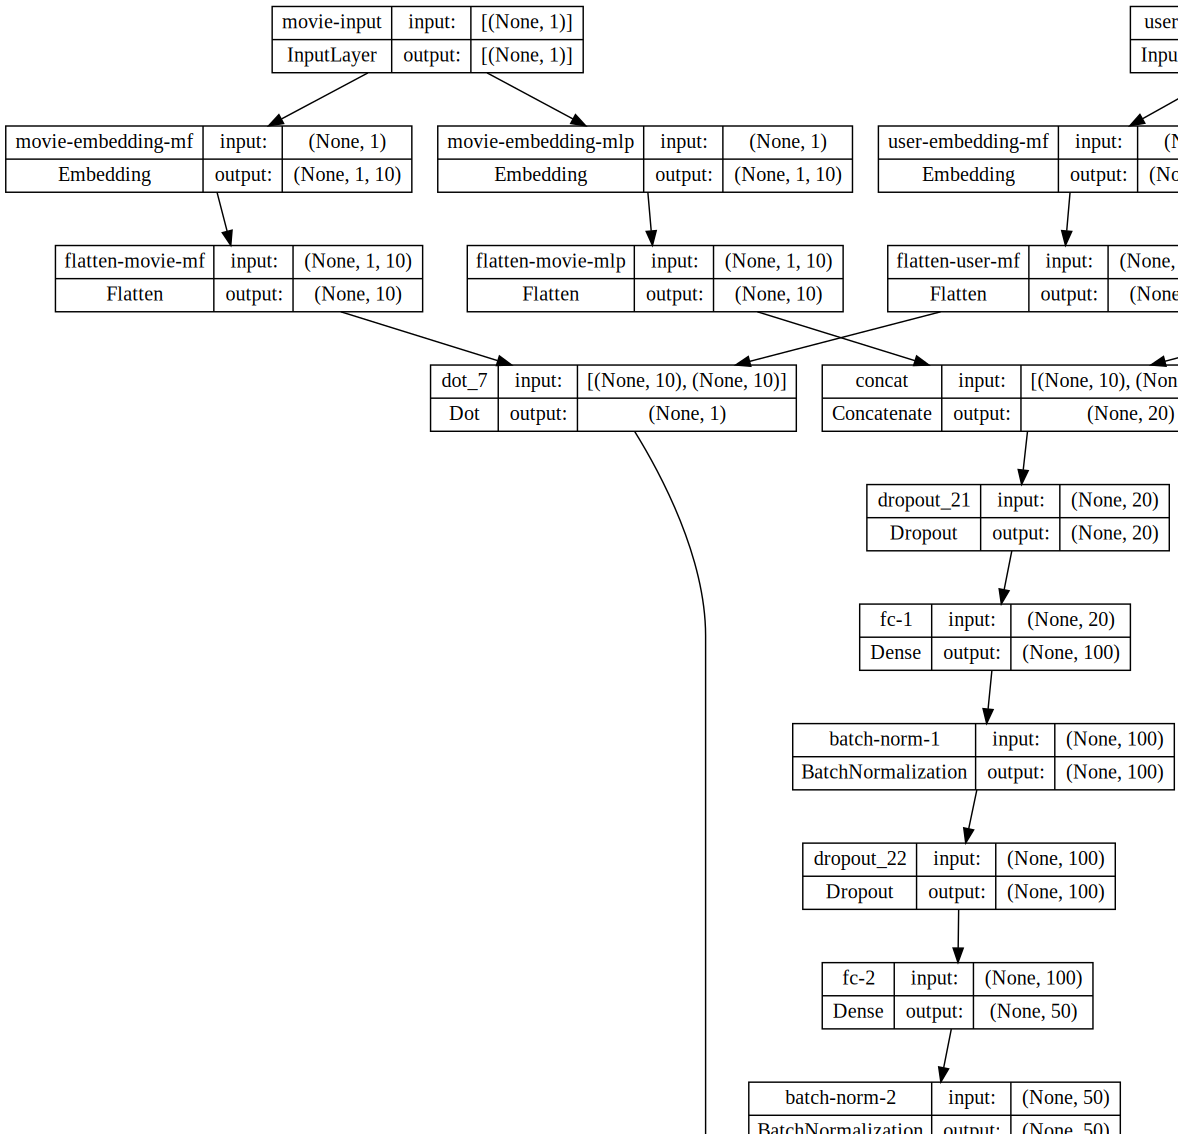

In [392]:
# визуализация модели
model = NCF_model()
SVG(model_to_dot(model, dpi=50, show_shapes=True).create(prog='dot', format='svg'))

In [393]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding-mlp (Embedding  (None, 1, 10)       28020       ['movie-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       610         ['user-input[0][0]']       

In [394]:
train['user_encoded']

28400    22
58956    39
3110      1
1563      0
90131    58
         ..
27521    19
21552    14
10349    10
66880    44
4130      4
Name: user_encoded, Length: 5764, dtype: int64

Epoch 1/10
181/181 [==============================] - 3s 6ms/step - loss: 1.8652
Epoch 2/10
181/181 [==============================] - 1s 5ms/step - loss: 0.7840
Epoch 3/10
181/181 [==============================] - 1s 4ms/step - loss: 0.4352
Epoch 4/10
181/181 [==============================] - 1s 5ms/step - loss: 0.2264
Epoch 5/10
181/181 [==============================] - 1s 8ms/step - loss: 0.1335
Epoch 6/10
181/181 [==============================] - 2s 8ms/step - loss: 0.0901
Epoch 7/10
181/181 [==============================] - 1s 6ms/step - loss: 0.0635
Epoch 8/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0477
Epoch 9/10
181/181 [==============================] - 1s 5ms/step - loss: 0.0380
Epoch 10/10
181/181 [==============================] - 1s 4ms/step - loss: 0.0318


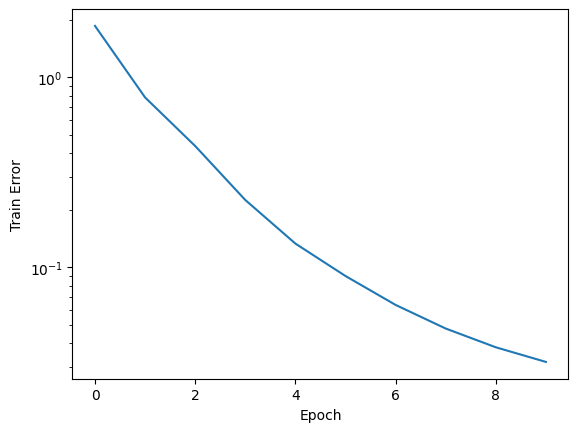

In [395]:
# обучение NCF
model = NCF_model(embed_size=20)
history = model.fit([train['user_encoded'], train['movie_encoded']], train['rating'], epochs=10)

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

In [396]:
# сохранение параметров модели
model.save('dl_model.h5')

In [397]:
# определение RMSE
y_pred = np.round(model.predict([test['user_encoded'], test['movie_encoded']]), decimals=2)
y_true = test['rating']
algo_ANN = 'ANN'
RMSE_ANN = (mean_squared_error(y_true, y_pred))**0.5
print(f'RMSE: {RMSE_ANN}')

46/46 [==============================] - 0s 3ms/step
RMSE: 1.0025444729119992


In [398]:
# формирование предсказаний
d = {'prediction': y_pred.tolist(), 'true_value': y_true.values.tolist()}
test_pred = pd.DataFrame(d)
test_pred.head(5)

,prediction,true_value
0,[1.9700000286102295],4.0
1,[3.450000047683716],4.0
2,[4.059999942779541],4.0
3,[3.9800000190734863],4.0
4,[4.78000020980835],5.0


In [399]:
def ANN_recommendation(model, target_user, target_qty = 10):
    '''
    Функция формирует заданное количество рекомендаций
    '''
    client_encoded = user2user_encoded[target_user]
    movie_watched = sample_df[sample_df['userId'] == target_user]['movieId'].values

    movie_poll_encoded = []
    for item in movie_ids:
        if not np.isin(item, movie_watched):
            movie_poll_encoded.append(movie2movie_encoded[item])

    d = {'user_encoded': [client_encoded] * len(movie_poll_encoded), 'movie_encoded' : movie_poll_encoded}
    client_df = pd.DataFrame(d)

    ratings = model.predict([client_df['user_encoded'], client_df['movie_encoded']])

    top_ratings_idx = ratings.flatten().argsort()[-target_qty:][::-1]
    top_ratings = ratings[top_ratings_idx].flatten()
    recommend_movieId = [movie_encoded2movie.get(movie_poll_encoded[x]) for x in top_ratings_idx]

    top_movie_rec = pd.DataFrame({'movieId': recommend_movieId, 'prediction': top_ratings}).set_index('movieId')
    top_movie_rec = top_movie_rec.join(movies.set_index('movieId'))

    return top_movie_rec

In [403]:
target_user = int(input('Введите uid пользователя, для которого необходимо сформировать рекомендацию:\t'))

Введите uid пользователя, для которого необходимо сформировать рекомендацию:	23


In [404]:
target_qty = int(input('Введите желаемое количество рекомендуемых фильмов:\t'))

Введите желаемое количество рекомендуемых фильмов:	10


In [405]:
print(f'Рекомендуемые фильмы:')
ANN_recommendation(model, target_user, target_qty)

Рекомендуемые фильмы:
84/84 [==============================] - 0s 2ms/step


,prediction,title,genres
movieId,,,
253,4.784018,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
355,4.594053,"Flintstones, The (1994)",Children|Comedy|Fantasy
2840,4.487584,Stigmata (1999),Drama|Thriller
2628,4.475363,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
122924,4.460470,X-Men: Apocalypse (2016),Action|Adventure|Fantasy|Sci-Fi
1246,4.452496,Dead Poets Society (1989),Drama
44,4.408446,Mortal Kombat (1995),Action|Adventure|Fantasy
61132,4.389396,Tropic Thunder (2008),Action|Adventure|Comedy|War
5181,4.384563,Hangar 18 (1980),Action|Sci-Fi|Thriller


### 5. SVD:

#### 5.1. Самостоятельная реализация SVD:

In [337]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

In [338]:
pd.crosstab(ratings['userId'], ratings['movieId'], ratings['rating'], aggfunc=sum)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [339]:
def rating_matrix(ratings):
    '''
    Пропуски заменяются на средний рейтинг
    Рейтинг нормализуется относительно среднего значения
    Выходы функции: R - numpy-массив рейтингов, df - DataFrame рейтингов
    '''

    umean = ratings.groupby(by='userId')['rating'].mean()   # расчет среднего рейтинга по пользователям

    df = pd.crosstab(ratings['userId'], ratings['movieId'], ratings['rating'], aggfunc=sum)
    df = df.fillna(df.mean(axis=0))   # заполнение пропусков

    df = df.subtract(umean, axis=0)   # нормализация

    R = df.to_numpy()   # перевод в numpy

    return R, df


R, df = rating_matrix(ratings)

In [340]:
df.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,-0.934561,-0.366379,-2.009236,-1.294951,-0.366379,-1.181194,-1.491379,-1.241379,-0.870167,...,-0.866379,-1.366379,-0.366379,-0.366379,-0.866379,-0.366379,-0.866379,-0.866379,-0.866379,-0.366379
2,-0.027346,-0.516458,-0.688660,-1.591133,-0.876847,-0.002197,-0.763091,-1.073276,-0.823276,-0.452064,...,-0.448276,-0.948276,0.051724,0.051724,-0.448276,0.051724,-0.448276,-0.448276,-0.448276,0.051724
3,1.485033,0.995921,0.823718,-0.078755,0.635531,1.510181,0.749288,0.439103,0.689103,1.060315,...,1.064103,0.564103,1.564103,1.564103,1.064103,1.564103,1.064103,1.064103,1.064103,1.564103
4,0.365375,-0.123737,-0.295940,-1.198413,-0.484127,0.390523,-0.370370,-0.680556,-0.430556,-0.059343,...,-0.055556,-0.555556,0.444444,0.444444,-0.055556,0.444444,-0.055556,-0.055556,-0.055556,0.444444
5,0.363636,-0.204545,-0.376748,-1.279221,-0.564935,0.309715,-0.451178,-0.761364,-0.511364,-0.140152,...,-0.136364,-0.636364,0.363636,0.363636,-0.136364,0.363636,-0.136364,-0.136364,-0.136364,0.363636


In [341]:
class SVD:

    def __init__(self, umean):
        '''
        входные данные: umean - средний рейтинг по пользователю
        '''
        self.umean = umean.to_numpy()

        self.P = np.array([])
        self.S = np.array([])
        self.Qh = np.array([])

        self.u_factors = np.array([])
        self.i_factors = np.array([])

    def fit(self, R):
        '''
        Расчет SVD рейтингов, сохранение матриц P, S, Q
        '''
        P, s, Qh = np.linalg.svd(R, full_matrices=False)

        self.P = P
        self.S = np.diag(s)
        self.Qh = Qh

        # скрытые факторы по пользователю и элементу
        self.u_factors = np.dot(self.P, np.sqrt(self.S))
        self.i_factors = np.dot(np.sqrt(self.S), self.Qh)

    def predict(self, userid, itemid):
        '''
        Предсказания по пользователю.
        Т.к. ранее вычитался фактический рейтинг из среднего,
        при расчете суммируются предсказание и средний рейтинг
        '''

        # предсказание по факторам пользователя и элемента
        r_pred = np.dot(self.u_factors[userid,:], self.i_factors[:,itemid])

        r_pred += self.umean[userid]

        return r_pred


    def recommend(self, userid):
        '''
        Формирование рекомендаций
        '''

        # предсказание для пользователя по факторам
        predictions = np.dot(self.u_factors[userid,:], self.i_factors) + self.umean[userid]

        # сортировка
        top_idx = np.flip(np.argsort(predictions))
        preds = predictions[top_idx]

        return top_idx, preds

In [342]:
umean = ratings.groupby(by='userId')['rating'].mean()

svd = SVD(umean)
svd.fit(R)

In [343]:
# определяемся с целевым пользователем и набором фильмов для формирования рекомендаций

target_user = int(input('Введите uid пользователя, для которого необходимо сформировать рекомендацию:\t'))

target_user_mov_qty = len(list(ratings[ratings['userId']==target_user]['movieId']))
print(f'Количество фильмов с рейтингом от указанного пользователя:\t{target_user_mov_qty}')
base_mov_qty = int(input('Введите количество фильмов выбранного пользователя для использования при формировании рекомендаций:\t'))

if base_mov_qty > target_user_mov_qty:
    print('Недостаточно рейтингов от данного пользователя')
else:
    base_films = list(ratings[ratings['userId']==target_user]['movieId'])[:base_mov_qty]
    r = svd.predict(userid=target_user, itemid=base_films)
    print('\nПредсказание для uid={} по фильмам iid={}:\n{}'.format(target_user, base_films, r))
    print(f'\nФактические рейтинги указанных фильмов от данного пользователя:')
    print((list(ratings['rating'][ratings['userId']==target_user]))[:base_mov_qty])

Введите uid пользователя, для которого необходимо сформировать рекомендацию:	10
Количество фильмов с рейтингом от указанного пользователя:	140
Введите количество фильмов выбранного пользователя для использования при формировании рекомендаций:	10

Предсказание для uid=10 по фильмам iid=[296, 356, 588, 597, 912, 1028, 1088, 1247, 1307, 1784]:
[2.84210526 3.5        2.5        2.81818182 4.22916667 3.75
 3.         4.         3.5        1.5       ]

Фактические рейтинги указанных фильмов от данного пользователя:
[1.0, 3.5, 4.0, 3.5, 4.0, 0.5, 3.0, 3.0, 3.0, 3.5]


In [344]:
# сортировка предсказаний
top_indx, preds = svd.recommend(userid=target_user)
rec_movies = movies[movies['movieId'].isin(top_indx)]

# списко фильмов, по которым пользователем проставлены рейтинги
uitems = ratings.loc[ratings['userId']==target_user]['movieId'].to_list()

# удаление фильмов, оцененных пользователем
top10 = np.setdiff1d(top_indx, uitems, assume_unique=True)[:18]

# формирование рекомендаций
top10_idx = list(np.where(top_indx == idx)[0][0] for idx in top10)
top10_predictions = preds[top10_idx]

# обогащение информацией по названию и жанру фильмов
zipped_top10 = list(zip(top10,top10_predictions))
top10 = pd.DataFrame(zipped_top10, columns=['movieId','predictions'])
recs_SVD_manual = pd.merge(top10, movies, on='movieId', how='inner')

recs_SVD_manual

,movieId,predictions,title,genres
0,1502,5.0,Kissed (1996),Drama|Romance
1,432,5.0,City Slickers II: The Legend of Curly's Gold (...,Adventure|Comedy|Western
2,531,5.0,"Secret Garden, The (1993)",Children|Drama
3,433,5.0,Clean Slate (1994),Comedy
4,121,5.0,"Boys of St. Vincent, The (1992)",Drama
5,87,5.0,Dunston Checks In (1996),Children|Comedy
6,405,5.0,Highlander III: The Sorcerer (a.k.a. Highlande...,Action|Fantasy
7,536,5.0,"Simple Twist of Fate, A (1994)",Drama
8,48,5.0,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
9,8136,5.0,Indestructible Man (1956),Crime|Horror|Sci-Fi


#### 5.2. Реализация SVD с использованием Surprise:

In [345]:
from surprise import SVD

In [346]:
algo = SVD()
algo.fit(trainset)

pred_SVD = algo.test(testset)

In [347]:
algo_SVD = 'SVD'
rmse_SVD = accuracy.rmse(pred_SVD)

RMSE: 0.8744


### 6. Non-Negative Matrix Factorization (NNMF):

In [348]:
from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
nmf = NMF(n_factors=30, n_epochs=70)

# кросс-валидация на 5 фолдах
nmf_cv = cross_validate(nmf, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9202  0.9124  0.9080  0.9128  0.9075  0.9122  0.0046  
Fit time          6.22    8.31    7.42    11.43   6.40    7.96    1.89    
Test time         0.13    0.14    0.38    0.15    0.12    0.18    0.10    


In [349]:
algo_NNMF = 'NNMF'
rmse_NNMF = nmf_cv['test_rmse'].mean()

In [350]:
print(f'RMSE: {round(rmse_NNMF, 4)}')

RMSE: 0.9122


### 7. Гибридная рекомендательная система:

In [351]:
# !pip install lightfm
from lightfm import LightFM
from scipy import sparse

In [352]:
movs_merged.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [353]:
def inter_mat(df, user_col, item_col, rating_col, threshold=0.):
    '''
    Формирование матрицы отношений
    '''
    inter = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index().fillna(0).set_index(user_col)
    inter = inter.applymap(lambda x: 1 if x > threshold else 0)
    return inter

In [354]:
def get_user_dict(inter):
    '''
    Формирование словаря по пользователям
    '''
    uid = list(inter.index)
    udict = {}
    count = 0
    for i in uid:
        udict[i] = count
        count += 1
    return udict

In [355]:
def get_item_dict(df, id_col, name_col):
    '''
    Формирование словаря по фильмам
    '''
    idict = {}
    length = df.shape[0]
    for i in range(length):
        idict[(df.loc[i, id_col])] = df.loc[i, name_col]
    return idict

In [356]:
def get_model(inter, n_components=20, k=10, loss='warp', epoch=20):
    '''
    Формирование и обучение модели
    '''
    x = sparse.csr_matrix(inter.values)
    model = LightFM(no_components=n_components, loss=loss, k=k)
    model.fit(x, epochs=epoch)
    return model

In [357]:
def get_rec_hybrid(model, inter, uid, udict, idict, threshold = 0, nrec_items = 10, show = True):
    '''
    Формирование рекомендаций
    '''
    cur_user = udict[uid]
    n_users, n_items = inter.shape
    scores = pd.Series(model.predict(cur_user, np.arange(n_items)))
    scores.index = inter.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    exist_items = list(pd.Series(inter.loc[uid,:] \
                                 [inter.loc[uid,:] > threshold].index) \
                       .sort_values(ascending=False))
    scores = [x for x in scores if x not in exist_items]

    score_list = scores[0:nrec_items]
    exist_items = list(pd.Series(exist_items).apply(lambda x: idict[x]))
    scores = list(pd.Series(score_list).apply(lambda x: idict[x]))
    print('Пользователю понравились следующие фильмы:')
    for i in exist_items[:10]:
        print('- ' + i)
    print('\nРекомендации для пользователя на основании указанных фильмов:')
    for i in scores:
        print('- ' + i)
    return score_list

In [358]:
inters = inter_mat(df=movs_merged, user_col='userId', item_col='movieId', rating_col='rating')
inters.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [359]:
udict = get_user_dict(inter=inters)
mov_dict = get_item_dict(df=movies, id_col='movieId', name_col='title')

In [360]:
model = get_model(inter=inters, n_components=20, loss = 'warp', epoch = 20)

In [361]:
target_user = int(input('Введите uid пользователя для формирования рекомендаций:\t'))

Введите uid пользователя для формирования рекомендаций:	10


In [363]:
rec_list = get_rec_hybrid(model=model, inter=inters, uid=target_user, udict=udict,
                              idict=mov_dict, show=True)

Пользователю понравились следующие фильмы:
- The Intern (2015)
- Magic Mike XXL (2015)
- Spectre (2015)
- The Second Best Exotic Marigold Hotel (2015)
- Kingsman: The Secret Service (2015)
- Pretty One, The (2013)
- The Hundred-Foot Journey (2014)
- Tangled Ever After (2012)
- Barefoot (2014)
- Interstellar (2014)

Рекомендации для пользователя на основании указанных фильмов:
- Harry Potter and the Goblet of Fire (2005)
- Ice Age (2002)
- Harry Potter and the Prisoner of Azkaban (2004)
- Harry Potter and the Chamber of Secrets (2002)
- Shrek 2 (2004)
- Monsters, Inc. (2001)
- Bruce Almighty (2003)
- Pirates of the Caribbean: The Curse of the Black Pearl (2003)
- Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
- Harry Potter and the Order of the Phoenix (2007)


###8. "Холодный старт" (рекомендации для новых пользователей):

In [364]:
target_user = int(input('Введите uid пользователя, для которого необходимо сформировать рекомендацию:\t'))
if target_user not in df_surp['uid'].values:
    print('Такого пользователя нет в базе данных')

    def get_cold_rec(dataset, qty):
        '''
        формирование рекомендаций для новых пользователей
        '''
        # среднее количество оценок на фильм
        mean_ratings = dataset.groupby('iid')['rating'].count().mean()
        # группировка по фильмам с фильтрацией фильмов только с количеством отзывов больше среднего
        df_grpd = (dataset.groupby('iid')['rating'].count() > mean_ratings).reset_index()
        df_grpd_popular = list(df_grpd['iid'][df_grpd['rating'] == True])
        # формирование 10 рекомендаций (популярные фильмы с наивысшим рейтингом)
        df_cold_rec = df_surp[dataset['iid'].isin(df_grpd_popular)].sort_values(by='rating', ascending=False)
        cold_rec = list(set(df_cold_rec['iid']))[:10]
        print('Популярные фильмы с высоким рейтингом:')
        return cold_rec

    target_qty = int(input('Введите желаемое количество рекомендуемых фильмов:\t'))

    cold_recs = get_cold_rec(df_surp, target_qty)
    for item in cold_recs:
        print(item)

else:
    print('Такой пользователь есть в базе данных, обратитесь к коду в других разделах')

Введите uid пользователя, для которого необходимо сформировать рекомендацию:	222222
Такого пользователя нет в базе данных
Введите желаемое количество рекомендуемых фильмов:	10
Популярные фильмы с высоким рейтингом:
Finding Nemo (2003)
Wolf (1994)
Son in Law (1993)
Master and Commander: The Far Side of the World (2003)
Lilo & Stitch (2002)
Mission to Mars (2000)
Monsoon Wedding (2001)
Brazil (1985)
Invasion of the Body Snatchers (1956)
The Martian (2015)


### 9. Выводы:

In [406]:
# формирование единого датафрейма с RMSE моделей по подходам 1-6:
df_models_rmse = pd.DataFrame([rmse_content, rmse_best_ub, rmse_best_ib, RMSE_ANN, rmse_SVD, rmse_NNMF], columns=['RMSE'])
df_models_names = pd.DataFrame([algo_content, f'User-based ({algo_best_ub})', f'Item-based ({algo_best_ib})', 'ANN', algo_SVD, algo_NNMF], columns=['Модель'])

df_comparison = pd.concat([df_models_names, df_models_rmse], axis=1).sort_values(by='RMSE')

df_comparison.style.bar(cmap='Reds', align='mid', vmin=0.7, vmax=1.1).hide_index()

Модель,RMSE
SVD,0.874445
Item-based (KNNBaseline),0.875695
User-based (KNNBaseline),0.879165
NNMF,0.912164
ANN,1.002544
Content-based,1.050749


- Построены рекомендательные модели на базе 8 подходов

- В т.ч. проработана проблема "холодного старта" (рекомендации для новых пользователей)

- По 6 из 8 (кроме гибридной и content-based RS) подходов качество моделей сравнено на базе метрики RMSE

- Лучшие метрики (RMSE ниже 0.88 баллов) показаны:
  - моделью на базе алгоритма SVD
  - item-based и user-based CF моделями на базе алгоритма KNNBaseline
  
- Достигнутые метрики качества удовлетворительны для организации опытной эксплуатации системы

- Для улучшения качества модели (применительно к опытной эксплуатации) возможен вариант учета давности отзыва пользователя отдельным весовым коэффициентом (более свежие отзывы - больший вес)

- Наихудшие метрики зафиксированы у моделей content-based и на базе искуственной нейронной сети

- В разделе ноутбука по user-based CF модели реализован полноценный пример диалоговой работы рекомендательной системы